In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
sys.path.append('../')
from src.data import train_val_test_split
from src.data import get_descriptor_and_labels

In [2]:
use_mda = True
numb_train_samples = 8_000
train_structs, val_structs, test_structs = train_val_test_split(mda=use_mda,num_files=None)

In [47]:
train_x, train_y, label_mapping = get_descriptor_and_labels(train_structs,num_samples_per_type=numb_train_samples)
val_x, val_y, _ = get_descriptor_and_labels(val_structs, num_samples_per_type=2_500)
test_x, test_y, _ = get_descriptor_and_labels(test_structs, num_samples_per_type=2_500)

# need to convert one-hot vectors to integers
train_y = np.argmax(train_y,axis=1)
val_y = np.argmax(val_y,axis=1)
test_y = np.argmax(test_y,axis=1)

In [48]:
label_mapping

{'hda': 0, 'lda': 1, 'mda': 2}

In [54]:
train_y

tensor([0, 0, 0,  ..., 2, 2, 2])

In [55]:
train_ys = []
test_ys = []
for i in range(3):
    train_ys.append(np.where(train_y==i,1,0))
    test_ys.append(np.where(test_y==i,1,0))

In [20]:
# # seperate test sets based on labels
# test_hda_desc = test_x[test_y==0]
# test_lda_desc = test_x[test_y==1]
# test_mda_desc = test_x[test_y==2]

# hda_labels = test_y[test_y==0]
# lda_labels = test_y[test_y==1]
# mda_labels = test_y[test_y==2]

0.988
0.8574666666666667
0.8425333333333334


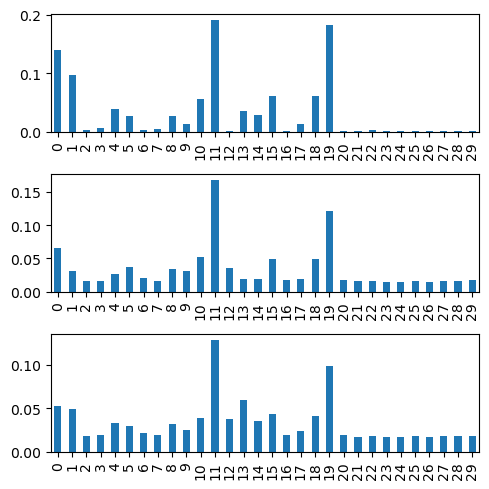

In [58]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
   
fig, axs = plt.subplots(3,1,figsize=(5,5))
model = RandomForestClassifier(random_state=0, n_estimators=300)

for i in range(3):
    model.fit(train_x,train_ys[i])
    print(model.score(test_x,test_ys[i]))
    
    importances = pd.Series(model.feature_importances_)
    importances.plot.bar(ax=axs[i])

# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
    

0.988
0.8574666666666667
0.8425333333333334


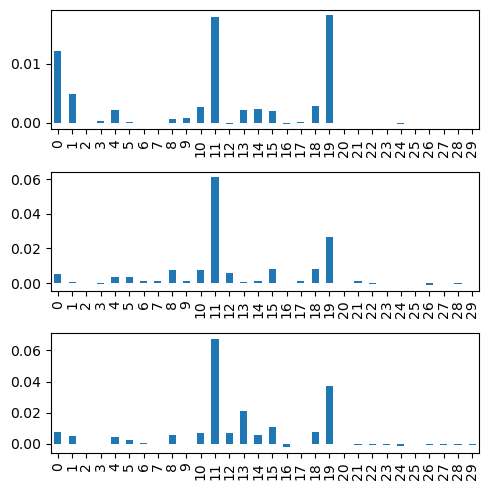

In [60]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
   
fig, axs = plt.subplots(3,1,figsize=(5,5))
model = RandomForestClassifier(random_state=0, n_estimators=300)

for i in range(3):
    model.fit(train_x,train_ys[i])
    print(model.score(test_x,test_ys[i]))
    result = permutation_importance(model, test_x, test_ys[i], n_repeats=10, random_state=42)
    importances = pd.Series(result.importances_mean)
    importances.plot.bar(ax=axs[i])

fig.tight_layout()

In [33]:
# get accuracy on test set
model.score(test_x,test_y)

0.8476

In [13]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

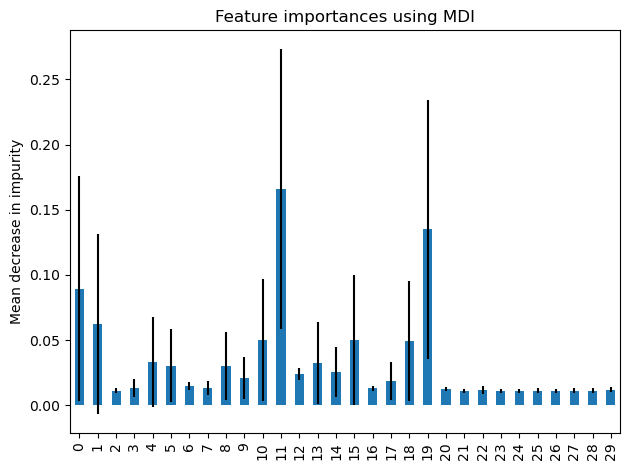

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [35]:
test_hda_desc.shape, hda_labels.shape

(torch.Size([2500, 30]), torch.Size([2500]))

In [39]:
from sklearn.inspection import permutation_importance

hda_result = permutation_importance(model, test_x, test_y, n_repeats=5, random_state=42)
# hda_result = permutation_importance(model, test_hda_desc, hda_labels, n_repeats=20, random_state=42)
# lda_result = permutation_importance(model, test_lda_desc, lda_labels, n_repeats=10, random_state=42)
# mda_result = permutation_importance(model, test_mda_desc, mda_labels, n_repeats=10, random_state=42)

In [40]:
hda_result

{'importances_mean': array([ 1.74933333e-02,  7.65333333e-03,  6.13333333e-04, -5.33333333e-05,
         7.68000000e-03,  4.66666667e-03,  3.04000000e-03,  6.40000000e-04,
         7.44000000e-03,  3.36000000e-03,  1.19200000e-02,  8.99733333e-02,
         8.66666667e-03,  4.53333333e-03,  2.96000000e-03,  1.38933333e-02,
         2.40000000e-04,  1.36000000e-03,  9.46666667e-03,  4.74133333e-02,
         4.26666667e-04, -2.66666667e-05, -5.33333333e-05, -8.00000000e-05,
         1.33333333e-04,  6.93333333e-04,  0.00000000e+00,  4.00000000e-04,
        -6.40000000e-04, -7.20000000e-04]),
 'importances_std': array([2.32382826e-03, 9.26066952e-04, 2.74550137e-04, 3.10984101e-04,
        7.38045467e-04, 8.30528613e-04, 5.22557812e-04, 6.04575149e-04,
        1.59421175e-03, 1.82311089e-03, 8.54166260e-04, 3.71078907e-03,
        1.22492630e-03, 8.51665036e-04, 1.26040558e-03, 2.20770368e-03,
        9.62958405e-04, 7.83836718e-04, 1.90624704e-03, 1.98948346e-03,
        4.87351117e-04, 4

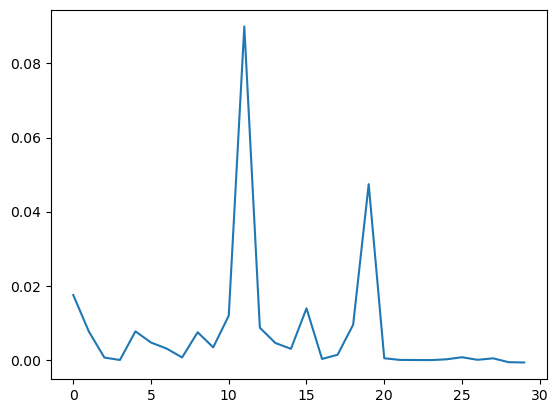

In [41]:
plt.plot(hda_result.importances_mean)

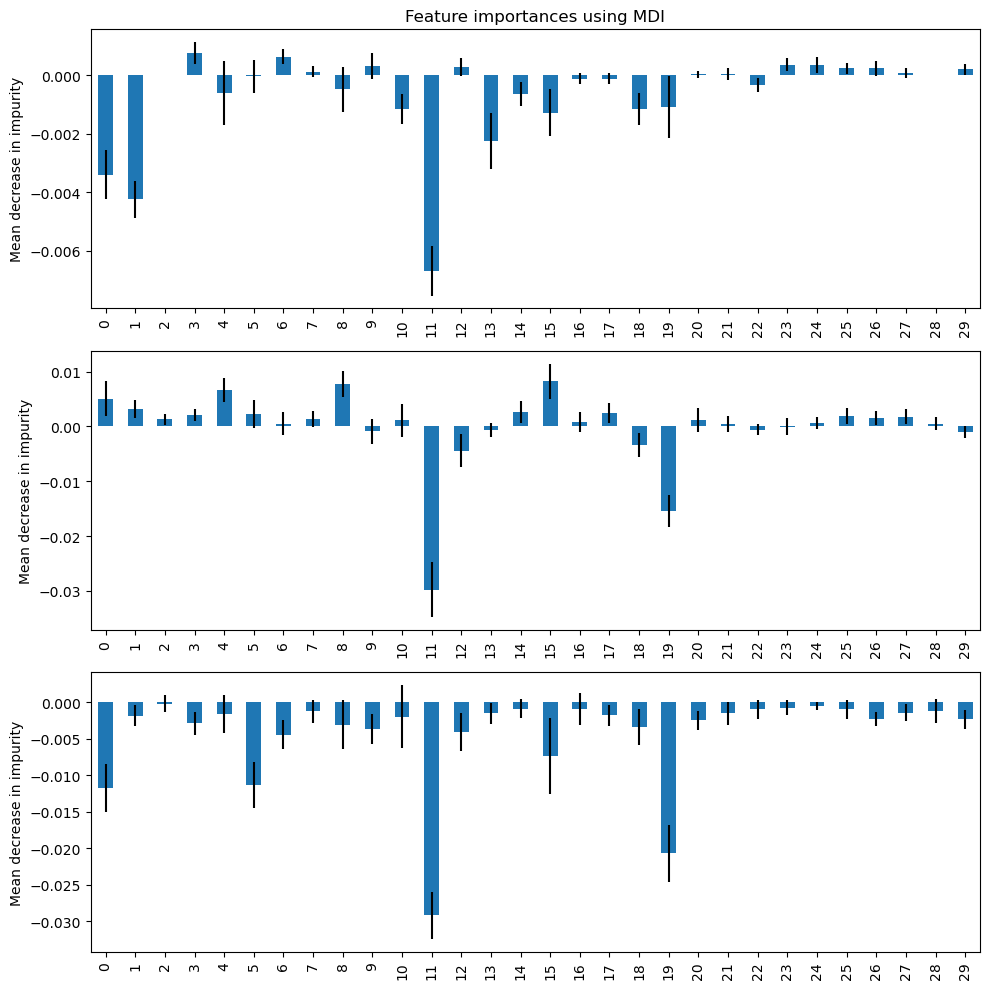

In [32]:
hda_importances = pd.Series(hda_result.importances_mean)
lda_importances = pd.Series(lda_result.importances_mean)
mda_importances = pd.Series(mda_result.importances_mean)

fig, axs = plt.subplots(3,1,figsize=(10,10))

hda_importances.plot.bar(yerr=hda_result.importances_std, ax=axs[0])
lda_importances.plot.bar(yerr=lda_result.importances_std, ax=axs[1])
mda_importances.plot.bar(yerr=mda_result.importances_std, ax=axs[2])

axs[0].set_title("Feature importances using MDI")
axs[0].set_ylabel("Mean decrease in impurity")
axs[1].set_ylabel("Mean decrease in impurity")
axs[2].set_ylabel("Mean decrease in impurity")
fig.tight_layout()


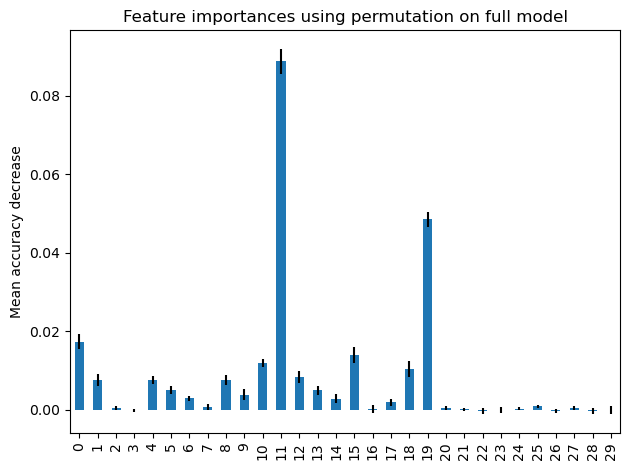

In [16]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()